In [1]:
# The task is to train a 3-layer multilayer perceptron using a real-encoded evolutionary
# algorithm for learning parity-3 problem (XOR-problem with 3 number of inputs).

# We have to find the near-optimal weights of the 3-layer perceptron by keeping the range of weights
# of the neural network between -1 and 1.

# Number of layers = 3 (1 input layer + 1 hidden layer + 1 output layer)
# Input layer will contain 3 neurons, corresponding to the three inputs.
# Hidden layer will have 6 neurons and the output layer will have 1 neuron.

# Activation function of hidden layer = sigmoid function
# Activation function of output layer = linear function (i.e., output = input)

# Fitness of each chromosome will be equal to the mean square of its genes.

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [3]:
# Parameters given for the problem
numInputs = 3
numHiddenNeurons = 6
numOutputs = 1 
pop_size = 20
crossOverRate = 0.7
weight_range = (-1, 1)
max_gen = 200

In [4]:
# Generating the inputs of a 3-input XOR logic gate
inputs = []

for num in range(2 ** numInputs):
    bin_inputs = [int(bit) for bit in format(num, '03b')]
    inputs.append(bin_inputs)
    
inputs = np.insert(np.array(inputs), 0, 1, axis=1) # Converting list to array and appending bias(= 1) at the start of each row

In [5]:
# Generating the output array of the 3-input XOR logic gate
desired_outputs = np.array([[reduce(type(inputs[0,0]).__xor__, row[1:]) for row in inputs]]).T

In [6]:
# Activation function for hidden layer
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [7]:
# Function to generate population of chromosomes

# note => The chromosomes generated will not contain the inputs, rather they will contain the weights and biases of 
#         the hidden and output layers (called weight encoding scheme). The size of each chromosome = I*H + H + H*O + O, where,
#               I -> number of input neurons
#               H -> number of hidden layer neurons
#               O -> number of output neurons
#         The format of each chromosome is as follows:
#               [w1_1, w1_2, w1_3,..., w1_H,..., wI_1, wI_2, wI_3,..., wI_H, b1, b2,..., bH, w1_1, w1_2, w1_3,..., w1_O,..., wH_1, wH_2, wH_3,..., wH_O, c1, c2,..., cO]
#                <---------------------------------------------------------><--------------><----------------------------------------------------------><-------------->
#                                Weights of each input neuron               Bias weights of                   Weights of each hidden neuron              Bias weights of
#                               to every neuron in hidden layer            each hidden neuron                     to every output neuron               each output neuron

def generatePopulation(size:int) -> list[list]:
    pop = []
    
    chr_size = numInputs*numHiddenNeurons + numHiddenNeurons + numHiddenNeurons*numOutputs + numOutputs
    for _ in range(size):
        chromosome = [random.uniform(weight_range[0], weight_range[1]) for _ in range(chr_size)]
        pop.append(chromosome)
    
    return pop

In [8]:
# Fitness function that calculates fitness of a chromosome
# Chromosome fitness = mean square of actual output - mean square of predicted output as derived by using chromosome

def getFitness(chromosome:list) -> float:
    
    # Extracting weights for input layer to hidden layer
    start = 0
    end = numInputs * numHiddenNeurons
    weights_ih = np.array([chromosome[start:end]]).reshape((numInputs, numHiddenNeurons))
    
    start = end
    end = start + numHiddenNeurons
    bias_ih = np.array([chromosome[start:end]])
    weights_ih = np.vstack((bias_ih, weights_ih))
    
    # Calculating the output of the hidden layer
    hidden_output = np.insert(sigmoid(np.dot(inputs, weights_ih)), 0, 1, axis=1)

    # Extracting weights for hidden layer to output layer
    start = end
    end = start + (numHiddenNeurons * numOutputs)
    weights_ho = np.array([chromosome[start:end]]).reshape((numHiddenNeurons, numOutputs))
    
    start = end
    end = start + numOutputs
    bias_ho = np.array([chromosome[start:end]])
    weights_ho = np.vstack((bias_ho, weights_ho))
    
    # Calculating the outputs
    predicted_outputs = np.dot(hidden_output, weights_ho)
    
    # Returning the mean square error
    return np.mean((desired_outputs - predicted_outputs) ** 2)

In [9]:
# Function to get mutant chromosome
def getMutant(population:list[list], best_chromosome):
    
    # Getting two random chromosomes from the population
    r1 = np.array(population[random.randint(0, pop_size-1)])
    r2 = np.array(population[random.randint(0, pop_size-1)])
    
    # Generating a random scaling factor, which will determine the influence of (r1-r2) on mutation
    F = random.random()
    
    # Returning the mutant chromosome array
    return best_chromosome + (F * (r1 - r2))

In [10]:
# Function to perform uniform cross-over between two chromosomes and produce the offspring
def uniform_crossover(parent1, parent2) -> list:
    child = []
    for i in range(len(parent1)):
        if random.random() <= crossOverRate:
            child.append(parent1[i])
        else:
            child.append(parent2[i])
            
    return child

In [11]:
fitness_curve = []
population = generatePopulation(pop_size)

for _ in range(max_gen):
    i = -1
    
    # Training the current generation
    while (i := i+1) < pop_size:
        
        # Finding the best chromosome of the current iteration
        fitness_values = [getFitness(chromosome) for chromosome in population]
        least_error = min(fitness_values)
        best = np.array(population[fitness_values.index(least_error)])
        
        fitness_curve.append(least_error)
        
        # Mutation
        mutant = getMutant(population, best)
        
        # Crossover
        trial = uniform_crossover(mutant, population[i])
        
        # Calculate fitness
        fitness_t = getFitness(trial)
        fitness_c = getFitness(population[i])
        
        # Selection; trial chromosome is selected if its mean square error is less
        if fitness_t < fitness_c:
            population[i] = trial

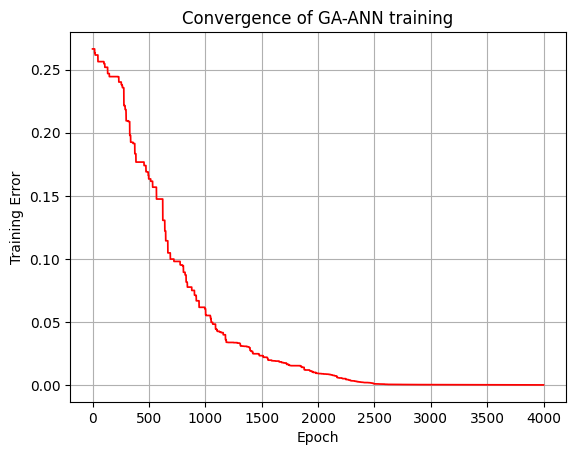

In [12]:
plt.plot(fitness_curve, linestyle='-', linewidth=1.25, color='red')
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.title("Convergence of GA-ANN training")
plt.grid(True)
plt.show()